# Correlation between entropy/FD metrics

In [1]:
import antropy as ant
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.signal import find_peaks
import seaborn as sns

sns.set(font_scale=1.25)
%config InlineBackend.figure_format = 'retina'

In [2]:
def synaptic_current(t, A, t_start, t_stop):
    """Input direct current value.

    Parameters
    ----------
    t : number or numpy.ndarray
        Time [ms]
    A : number
        Stimulus amplitude [nA]
    t_start : number
        Time point marking the start of stimulus input [ms]
    t_stop : number
        Time point marking the end of stimulus input [ms]

    Returns
    -------
    float or numpy.ndarray
        Current in time
    """
    return A * (t > t_start) - A * (t > t_stop)

In [3]:
def hodgkin_huxley_model(y0, t, A, t_start, t_stop, *args):
    """Return the change in state variables of the neuron.

    Parameters
    ----------
    y0 : numpy.ndarray or list or tuple
        Initial conditions for resting membrane potential and `m`, `h`
        and `n` kinetic variables
    t : numpy.ndarray
        Sequence of time points for which to solve for state variables
    A : number
        Stimulus amplitude [nA]
    t_start : number
        Time point marking the start of stimulus input [ms]
    t_stop : number
        Time point marking the end of stimulus input [ms]
    kwargs : dict
        g_Na : number
            Sodium (Na) maximum conductance [mS/cm^2]
        g_K : number
            Postassium (K) maximum conductance [mS/cm^2]
        g_L : number
            Leak maximum conductance [mS/cm^2]
        Cm : number
            Membrane capacitance [F/cm^2]
        E_Na : number
            Sodium (Na) reversal potentials [mV]
        E_K : number
            Postassium (K) reversal potentials [mV]
        E_L : number
            Leak reversal potentials [mV]

    Returns
    -------
    numpy.ndarray
        State variables dynamics of shape (`t.size`, 4).
    """
    Vm, m, h, n = y0
    dVmdt = ((synaptic_current(t, A, t_start, t_stop)
               - g_Na * m ** 3 * h * (Vm - E_Na)
               - g_K * n ** 4 * (Vm - E_K)
               - g_L * (Vm - E_L)) / Cm)
    dmdt = (0.1 * (Vm + 40) / (1.0 - np.exp(-(Vm + 40) / 10.))
            * (1.0 - m) - 4 * np.exp(-(Vm + 65) / 18.) * m)
    dhdt = (0.07 * np.exp(-(Vm + 65) / 20) * (1 - h)
            - 1 / (1.0 + np.exp(-(Vm + 35) / 10.)) * h)
    dndt = (0.01 * (Vm + 55) / (1.0 - np.exp(-(Vm + 55) / 10))
            * (1 - n) - 0.125 * np.exp(-(Vm + 65) / 80) * n)
    return np.hstack([dVmdt, dmdt, dhdt, dndt])

In [4]:
# Set Hodgin-Huxley parameters
A = 10  # nA
t_start = 100  # ms
t_stop = 400  # ms
g_Na = 120  # mS/cm^2
g_K = 36  # mS/cm^2
g_L = 0.3  # mS/cm^2
Cm = 1  # F/cm^2
E_Na = 50  # mV
E_K = -77  # mV
E_L = -54.4  # mV
y0 = [-65., 0.0529, 0.5916, 0.3177]  # initial conditions
t = np.arange(0., 500., 0.1)  # time domain

In [5]:
# Solve the ODE system
I = synaptic_current(t, A, t_start, t_stop)
args = (A, t_start, t_stop, g_Na, g_K, g_L, Cm, E_Na, E_K, E_L)
Vm = odeint(hodgkin_huxley_model, y0, t, args=args)[:, 0]

# Cunt the number of spikes...
thresh = -40
n_spikes = find_peaks(Vm, height=thresh)[0].size
# ... and propose a sampling frequency
sf = (n_spikes + 1) * 2

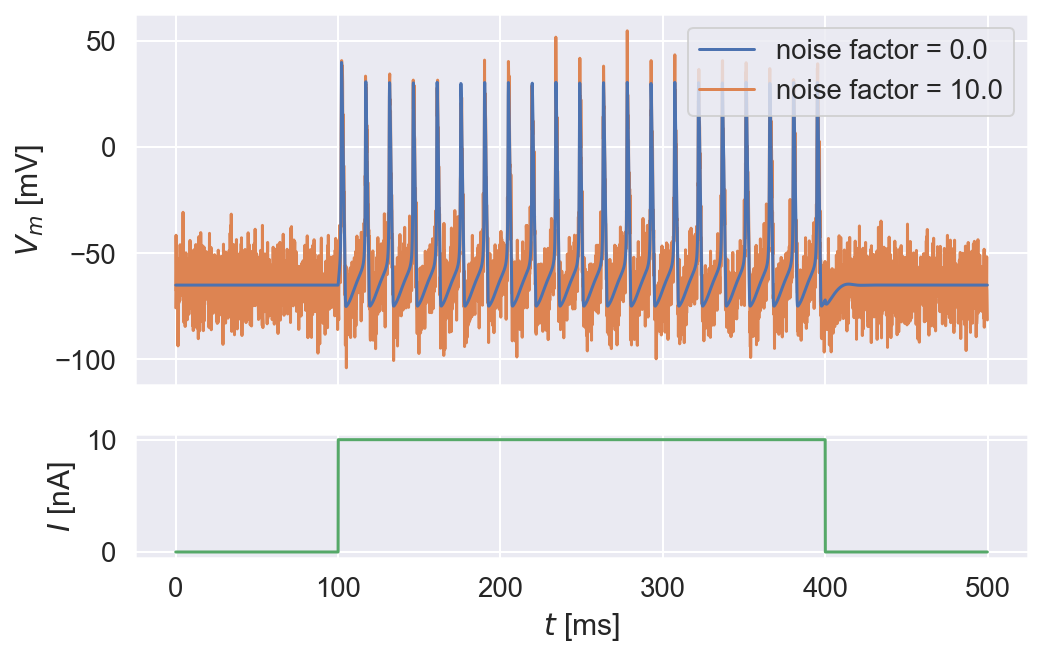

In [6]:
# Generate 100 voltage traces with increasing noise...
np.random.seed(42)
n_simulations = 100
noise_factor = np.linspace(0, 10, n_simulations)
neural_noise = np.random.randn(n_simulations, t.size)
traces = np.zeros((n_simulations, t.size))
for i in range(n_simulations):
    traces[i] = Vm + noise_factor[i] * neural_noise[i, :]
    
# ...and plot the first and last traces
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False,
                       gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5))

ax[0].plot(t, traces[0], label=f'noise factor = {noise_factor[0]}', zorder=2)
ax[0].plot(t, traces[-1], label=f'noise factor = {noise_factor[-1]}', zorder=1)
ax[0].set_ylabel('$V_m$ [mV]')
ax[0].legend()

ax[1].plot(t, I, 'C2')
ax[1].set_xlabel('$t$ [ms]')
ax[1].set_ylabel('$I$ [nA]')

plt.show()

In [7]:
# Compute the entropy metrics
df = pd.DataFrame()

cutoff = np.where((t == t_start) | (t == t_stop))[0]
traces = traces[:, cutoff[0]:cutoff[-1]]
for i in range(n_simulations):
    df = df.append({
        'PermEnt': ant.perm_entropy(traces[i], order=3, normalize=True),
        'SVDEnt' : ant.svd_entropy(traces[i], order=3, normalize=True),
        'SpecEnt' : ant.spectral_entropy(traces[i], sf=sf, normalize=True),
        'AppEnt': ant.app_entropy(traces[i], order=2),
        'SampleEnt': ant.sample_entropy(traces[i], order=2),
        'PetrosianFD': ant.petrosian_fd(traces[i]),
        'KatzFD': ant.katz_fd(traces[i]),
        'HiguchiFD': ant.higuchi_fd(traces[i]),
        'DFA': ant.detrended_fluctuation(traces[i])}, ignore_index=True)

df.head().round(3)

,AppEnt,DFA,HiguchiFD,KatzFD,PermEnt,PetrosianFD,SVDEnt,SampleEnt,SpecEnt
0,0.104,1.325,1.059,1.878,0.306,1.001,0.191,0.038,0.358
1,0.107,1.325,1.061,1.881,0.572,1.008,0.192,0.043,0.358
2,0.112,1.325,1.073,1.897,0.799,1.016,0.193,0.048,0.358
3,0.119,1.324,1.092,1.919,0.894,1.020,0.194,0.056,0.358
4,0.125,1.324,1.108,1.943,0.919,1.021,0.196,0.064,0.358


In [8]:
# Describe
df.agg(['min', 'median', 'max']).round(2).T

,min,median,max
AppEnt,0.10,0.96,1.46
DFA,1.15,1.25,1.32
HiguchiFD,1.06,1.57,1.76
KatzFD,1.88,2.80,3.86
PermEnt,0.31,1.00,1.00
PetrosianFD,1.00,1.03,1.03
SVDEnt,0.19,0.36,0.52
SampleEnt,0.04,0.85,1.38
SpecEnt,0.36,0.40,0.50


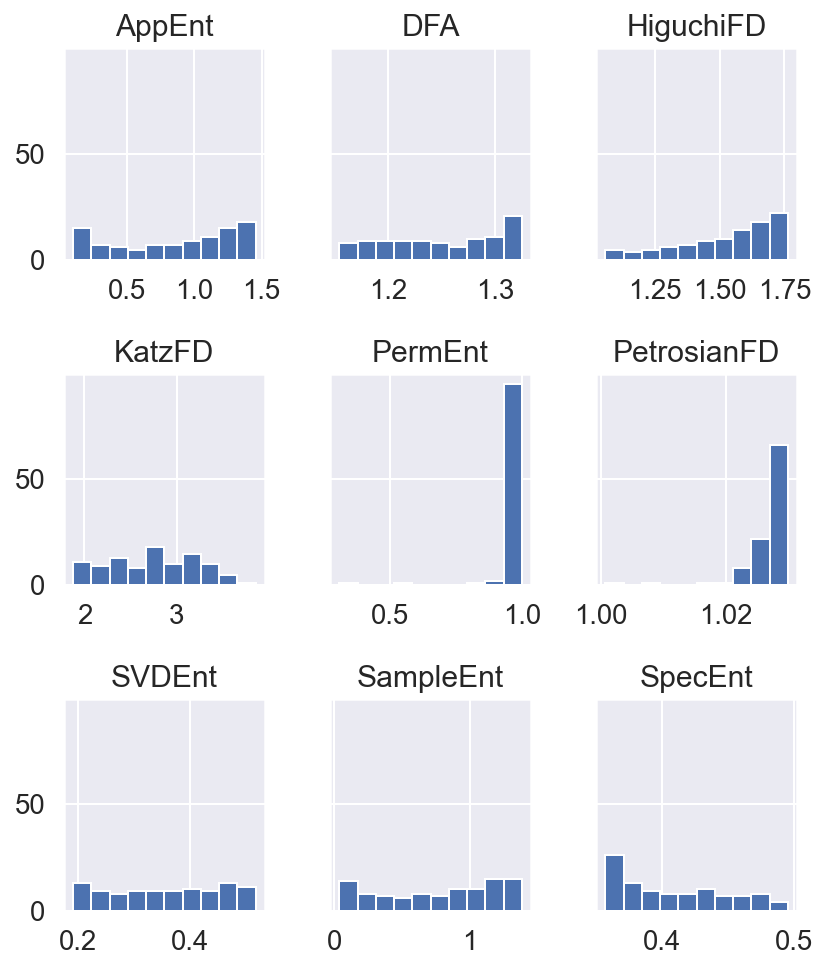

In [9]:
df.hist(figsize=(6, 7), layout=(3, 3), sharey=True)
plt.tight_layout()

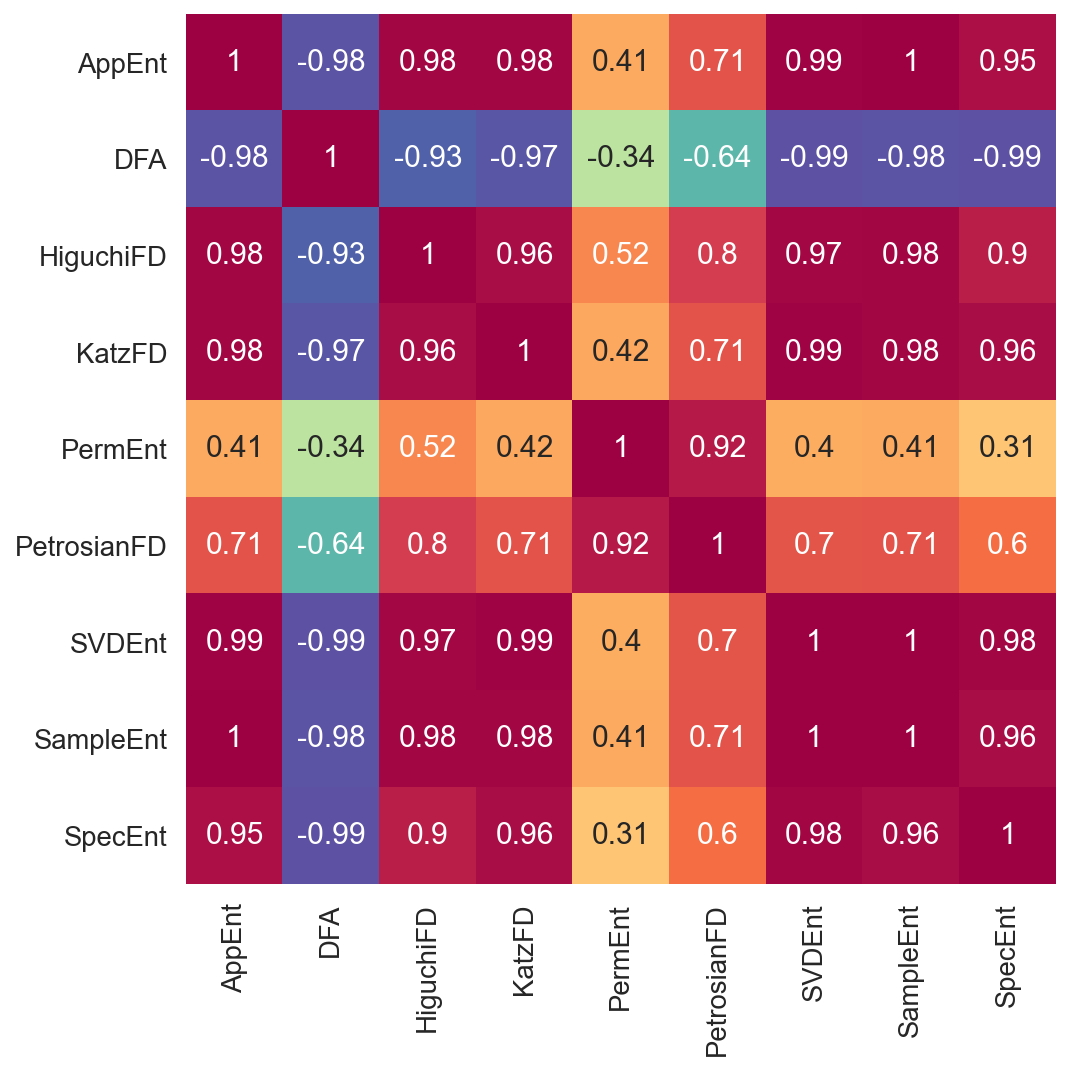

In [10]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr().round(2), annot=True, vmin=-1, vmax=1, cbar=False,
            cmap='Spectral_r', square=True);

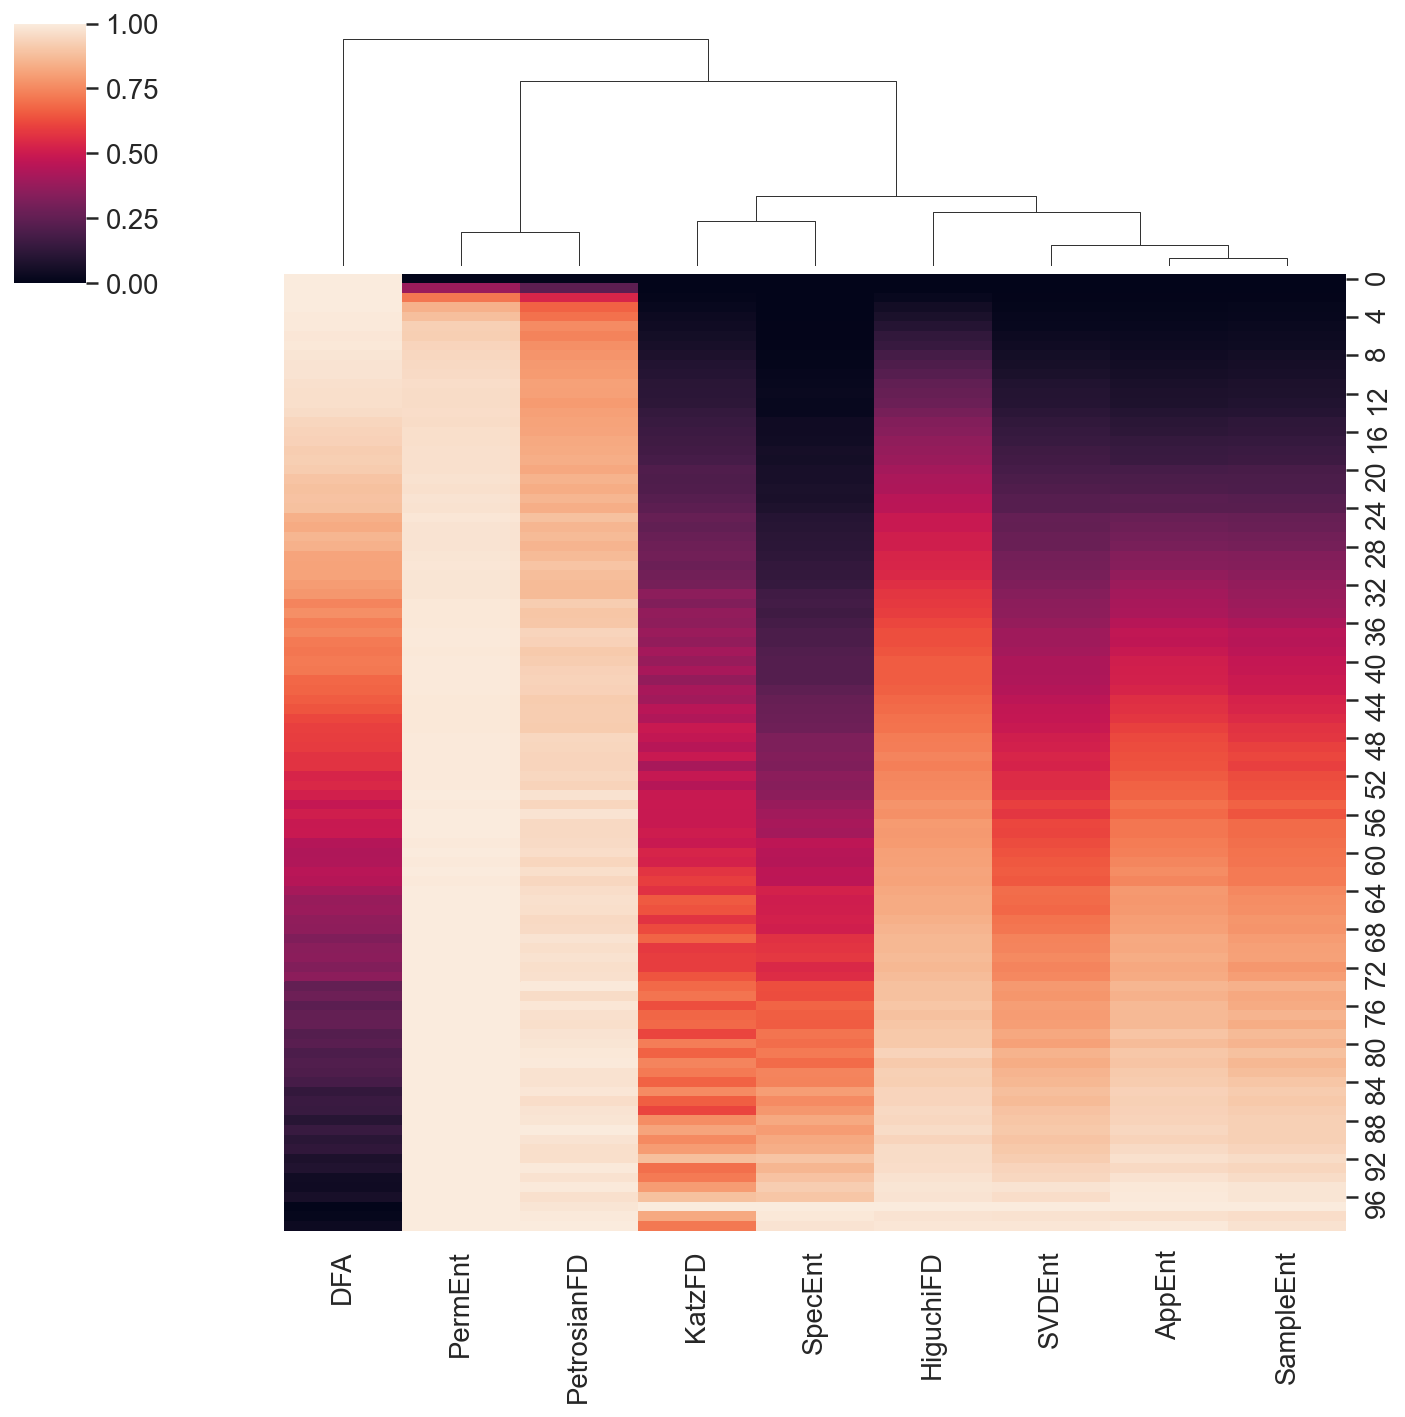

In [11]:
sns.clustermap(df, row_cluster=False, standard_scale=1);